# Importation

In [9]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Séparation test et entrainement

In [10]:
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# train_df.to_csv('../data/train.csv', index=False)
# test_df.to_csv('../data/test.csv', index=False)


### Ouvrir les csv qui ont déjà été divisés

In [11]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# Variables

In [12]:
x_train = train_df['recette']
y_train = train_df['type']
y_test = test_df['type']



# Baseline 

### Prédiction aléatoire

In [13]:
def random_prediction():
    return random.choice(['Plat principal', 'Entrée', 'Dessert'])

test_df['random prediction'] = test_df.apply(lambda x: random_prediction(), axis=1)


### Prédiction classe majoritaire

In [14]:
def main_class_prediction(train_df):
    main_type = train_df['type'].mode()    
    return main_type

main_type = main_class_prediction(train_df)
test_df['main class prediction'] = test_df.apply(lambda x: main_type, axis=1)

# Normalisation

In [17]:
# Télécharger les ressources nécessaires pour nltk (la première fois seulement)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

def normalize_text(text):
    # Conversion en minuscules
    text = text.lower()
    # Suppression de la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenization
    tokens = word_tokenize(text)
    # Suppression des mots vides
    stop_words = set(stopwords.words('french'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Rejoindre les tokens en une seule chaîne de caractères
    normalized_text = ' '.join(tokens)
    return normalized_text

# Appliquer la normalisation à une colonne du DataFrame
train_df['recette_normalized'] = train_df['recette'].apply(normalize_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Model

### SKlearn + Tfi-Df

In [15]:
def TfiDf_Sklearn(x_train, y_train, test_df):
    
    model1 = make_pipeline(TfidfVectorizer(), MultinomialNB())

    model1.fit(x_train, y_train)

    y_pred_Sklearn = model1.predict(test_df['recette'])

    test_df['Tfi-Df prediction'] = y_pred_Sklearn

    return y_pred_Sklearn

y_pred_Sklearn = TfiDf_Sklearn(x_train, y_train, test_df)

### Avec normalisation

In [16]:
y_pred_Sklearn_normalized = TfiDf_Sklearn(train_df['recette_normalized'], y_train, test_df)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Spacy

In [29]:
def spacyclassifier(x_train, y_train, test_df):
    model2 = make_pipeline()

    model2.fit(x_train, y_train)

    y_pred_spacy = model2.predict(test_df['recette'])

    test_df['spacy prediction'] = y_pred_spacy

    return y_pred_spacy

# Résultat

In [23]:
def results(y_model, y_test):

    conf_matrix = confusion_matrix(y_test, y_model)

    conf_df = pd.DataFrame(conf_matrix)

    print("Matrice de Confusion : \n", conf_df)

    plt.figure(figsize=(8,6))
    sns.heatmap(conf_df, annot=True, cmap="YlGnBu", fmt='g')
    plt.title('Matrice de Confusion')
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs Réelles')
    plt.show()

    # Rappel - Precision - F1-score

    report = classification_report(y_test, y_model)
    print(report)

## Random

Matrice de Confusion : 
      0    1    2
0  154  133  120
1   88  130  119
2  204  205  235


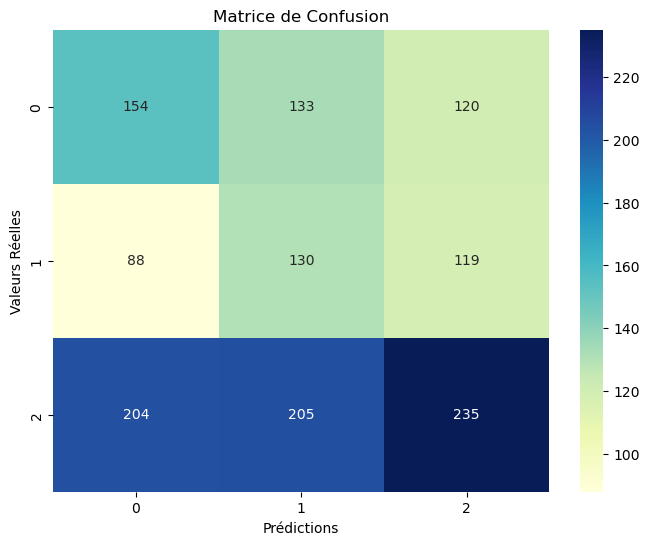

                precision    recall  f1-score   support

       Dessert       0.35      0.38      0.36       407
        Entrée       0.28      0.39      0.32       337
Plat principal       0.50      0.36      0.42       644

      accuracy                           0.37      1388
     macro avg       0.37      0.38      0.37      1388
  weighted avg       0.40      0.37      0.38      1388



In [24]:
y_rand = test_df['random prediction']
results(y_rand, y_test)

## Main

Matrice de Confusion : 
    0  1    2
0  0  0  407
1  0  0  337
2  0  0  644


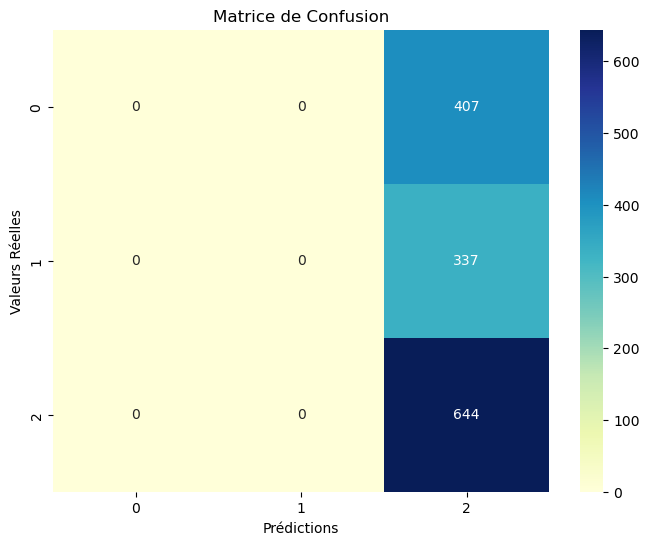

                precision    recall  f1-score   support

       Dessert       0.00      0.00      0.00       407
        Entrée       0.00      0.00      0.00       337
Plat principal       0.46      1.00      0.63       644

      accuracy                           0.46      1388
     macro avg       0.15      0.33      0.21      1388
  weighted avg       0.22      0.46      0.29      1388



c:\Users\Nicolas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nicolas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nicolas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
y_main = test_df['main class prediction']
results(y_main, y_test)

### Sklearn + Tfi-DF

Matrice de Confusion : 
      0   1    2
0  395   0   12
1   14  24  299
2    6   2  636


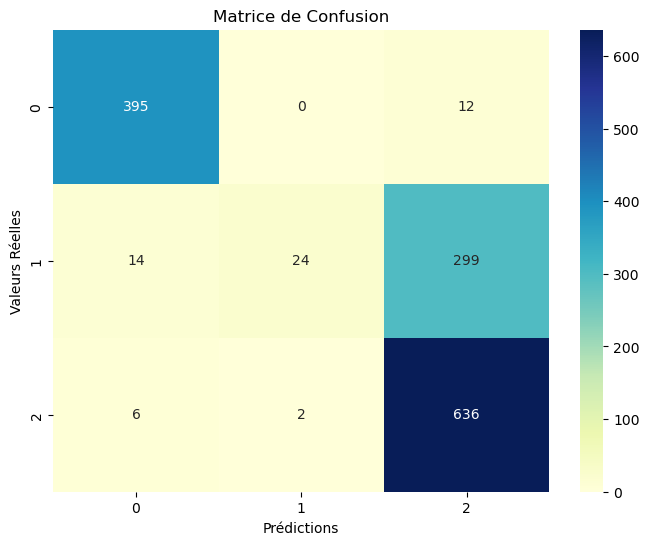

                precision    recall  f1-score   support

       Dessert       0.95      0.97      0.96       407
        Entrée       0.92      0.07      0.13       337
Plat principal       0.67      0.99      0.80       644

      accuracy                           0.76      1388
     macro avg       0.85      0.68      0.63      1388
  weighted avg       0.81      0.76      0.68      1388



In [27]:
results(y_pred_Sklearn, y_test)

### Spacy

Matrice de Confusion : 
                 Dessert  Entrée  Plat principal
Dessert             405       1               1
Entrée                5     233              99
Plat principal        5      61             578


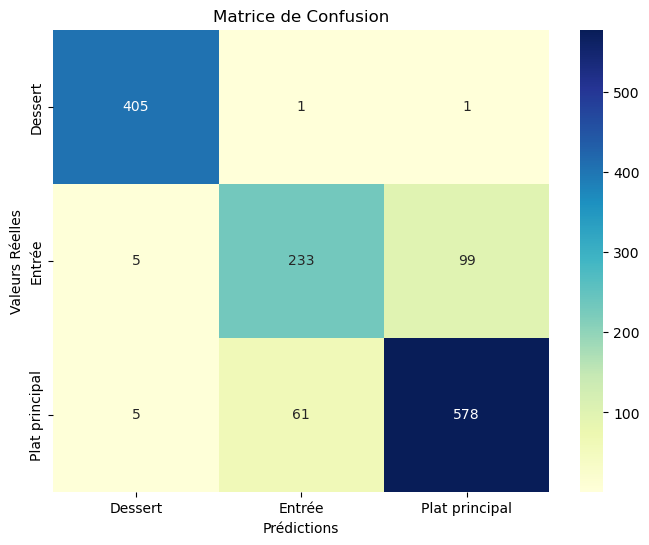

                precision    recall  f1-score   support

       Dessert       0.98      1.00      0.99       407
        Entrée       0.79      0.69      0.74       337
Plat principal       0.85      0.90      0.87       644

      accuracy                           0.88      1388
     macro avg       0.87      0.86      0.87      1388
  weighted avg       0.87      0.88      0.87      1388



In [ ]:
results(y_pred_spacy, y_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Compute evaluation metrics
accuracy = accuracy_score(test_df["type"], y_pred_spacy)
precision = precision_score(test_df["type"], y_pred_spacy, average='weighted')
recall = recall_score(test_df["type"], y_pred_spacy, average='weighted')
f1 = f1_score(test_df["type"], y_pred_spacy, average='weighted')
conf_matrix = confusion_matrix(test_df["type"], y_pred_spacy)
class_report = classification_report(test_df["type"], y_pred_spacy)

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Evaluation Metrics:
Accuracy: 0.8760806916426513
Precision: 0.87347291188963
Recall: 0.8760806916426513
F1 Score: 0.8736867549379232
Confusion Matrix:
[[405   1   1]
 [  5 233  99]
 [  5  61 578]]
Classification Report:
                precision    recall  f1-score   support

       Dessert       0.98      1.00      0.99       407
        Entrée       0.79      0.69      0.74       337
Plat principal       0.85      0.90      0.87       644

      accuracy                           0.88      1388
     macro avg       0.87      0.86      0.87      1388
  weighted avg       0.87      0.88      0.87      1388

